# Graph learning

<!-- ## JanusGraph-Visualizer queries

- Visualize only the collaboration pattern nodes, situation nodes, and action nodes
  - `g.V().not(hasLabel(containing("participant_").or(eq("robot"))))`
- Visualize the situation vertices of interest
  - `g.V().hasLabel("situation_1", "situation_2")` -->

## Start HumemAI

In [1]:
from humemai.utils import disable_logger
disable_logger()

from gremlin_python.structure.graph import Graph, Vertex, Edge
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.driver.serializer import GraphSONSerializersV3d0
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.traversal import P, T, Direction

import json
from humemai.janusgraph import Humemai
from tqdm.auto import tqdm

humemai = Humemai()
humemai.connect()


# humemai.remove_all_data()
# humemai.disconnect()
# humemai.stop_docker_compose()
# humemai.remove_docker_compose()

from humemai.utils import disable_logger
disable_logger()

/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DEBUG:humemai.janusgraph.utils.docker:Starting Docker Compose with project name 'jce' using file '/home/tk/repos/humemai/humemai/janusgraph/docker-compose-cql-es.yml'...
DEBUG:humemai.janusgraph.utils.docker:Waiting for 30 seconds to allow containers to warm up...
INFO:humemai.janusgraph.utils.docker:Docker Compose started successfully.
DEBUG:humemai.janusgraph.utils.docker:
DEBUG:humemai.janusgraph.humemai:Attempting to establish a new connection to the Gremlin server.
DEBUG:humemai.janusgraph.humemai:Gremlin server URL: ws://localhost:8182/gremlin
INFO:gremlinpython:Creating DriverRemoteConnection with url 'ws://localhost:8182/gremlin'
INFO:gremlinpython:Creating Client with url 'ws://localhost:8182/gremlin'
INFO:gremlinpyth

## Write the co-learning data to HumemAI

In [117]:
with open("./raw-data.json") as f:
    data = json.load(f)


humemai.remove_all_data()


for data_point in tqdm(data):
    event_time = data_point["timestamp"]

    robot_vertex = humemai.write_long_term_vertex("robot", {"event_time": event_time})
    cp_properties = {
        "cp_num": data_point["cp_num"],
        "participant_num": data_point["participant"],
        "cp_name": data_point["cp_name"],
        "ticks_lasted": data_point["ticks_lasted"],
        "round_num": data_point["round_num"],
        "event_time": data_point["timestamp"],
        "remaining_time": data_point["remaining_time"],
        "remaining_rocks": data_point["remaining_rocks"],
        "victim_harm": data_point["victim_harm"],
    }

    cp_vertex = humemai.write_long_term_vertex("CP", cp_properties)
    humemai.write_long_term_edge(
        robot_vertex, "has_cp", cp_vertex, {"event_time": event_time}
    )

    participant_vertex = humemai.write_long_term_vertex(
        "participant",
        {"participant_number": data_point["participant"], "event_time": event_time},
    )
    humemai.write_long_term_edge(
        participant_vertex, "has_cp", cp_vertex, {"event_time": event_time}
    )

    situation = [bar for foo in data_point["situation"] for bar in foo]

    if situation:
        situation_properties = {s["type"]: s["content"] for s in situation}
        situation_properties["event_time"] = event_time
        situation_vertex = humemai.write_long_term_vertex(
            "situation", situation_properties
        )
        humemai.write_long_term_edge(
            cp_vertex, "has_situation", situation_vertex, {"event_time": event_time}
        )

        for idx, list_ in enumerate(data_point["HumanAction"]):

            if list_:
                properties = {"event_time": event_time}
                for action in list_:
                    properties[action["type"]] = action["content"]
                properties["action_number"] = idx

                human_action_vertex = humemai.write_long_term_vertex(
                    "human_action", properties
                )
                humemai.write_long_term_edge(
                    situation_vertex,
                    "has_human_action_" + str(idx),
                    human_action_vertex,
                    {"event_time": event_time},
                )

        for idx, list_ in enumerate(data_point["RobotAction"]):

            if list_:
                properties = {"event_time": event_time}
                for action in list_:
                    properties[action["type"]] = action["content"]
                properties["action_number"] = idx

                robot_action_vertex = humemai.write_long_term_vertex(
                    "robot_action", properties
                )
                humemai.write_long_term_edge(
                    situation_vertex,
                    "has_robot_action_" + str(idx),
                    robot_action_vertex,
                    {"event_time": event_time},
                )

# # Merge the duplicate nodes
# humemai.connect_duplicate_vertices("exact_label")

100%|██████████| 211/211 [00:02<00:00, 94.03it/s] 


### `g.V()`
![g.V().png](./figures/g.V().png)


### `g.V().has("cp_num", 36)`
![cp_36.png](./figures/cp_36.png)
![cp_36_CP.png](./figures/cp_36_CP.png)
![cp_36_situation.png](./figures/cp_36_situation.png)
![cp_36_participant.png](./figures/cp_36_participant.png)
![cp_36_robot.png](./figures/cp_36_robot.png)
![cp_36_human_action_0.png](./figures/cp_36_human_action_0.png)
![cp_36_robot_action_0.png](./figures/cp_36_robot_action_0.png)
![cp_36_robot_action_1.png](./figures/cp_36_robot_action_1.png)


## Get some stats

In [118]:
from gremlin_python.process.traversal import TextP

ticks_lasted_min = (
    humemai.g.V().hasLabel("CP").values("ticks_lasted").order().limit(1).next()
)

ticks_lasted_max = (
    humemai.g.V().hasLabel("CP").values("ticks_lasted").order().tail(1).next()
)

remaining_time_min = (
    humemai.g.V().hasLabel("CP").values("remaining_time").order().limit(1).next()
)

remaining_time_max = (
    humemai.g.V().hasLabel("CP").values("remaining_time").order().tail(1).next()
)

remaining_rocks_min = (
    humemai.g.V().hasLabel("CP").values("remaining_rocks").order().limit(1).next()
)

remaining_rocks_max = (
    humemai.g.V().hasLabel("CP").values("remaining_rocks").order().tail(1).next()
)

victim_harm_min = (
    humemai.g.V().hasLabel("CP").values("victim_harm").order().limit(1).next()
)

victim_harm_max = (
    humemai.g.V().hasLabel("CP").values("victim_harm").order().tail(1).next()
)

round_num_min = humemai.g.V().hasLabel("CP").values("round_num").order().limit(1).next()

round_num_max = humemai.g.V().hasLabel("CP").values("round_num").order().tail(1).next()

print(f"{'Description':<20}{'Min':<10}{'Max':<10}")
print(f"{'-' * 40}")
print(f"{'Ticks lasted:':<20}{ticks_lasted_min:<10}{ticks_lasted_max:<10}")
print(f"{'Remaining time:':<20}{remaining_time_min:<10}{remaining_time_max:<10}")
print(f"{'Remaining rocks:':<20}{remaining_rocks_min:<10}{remaining_rocks_max:<10}")
print(f"{'Victim harm:':<20}{victim_harm_min:<10}{victim_harm_max:<10}")
print(f"{'Round number:':<20}{round_num_min:<10}{round_num_max:<10}")

Description         Min       Max       
----------------------------------------
Ticks lasted:       1         3018      
Remaining time:     887       3000      
Remaining rocks:    0         41        
Victim harm:        0         1900      
Round number:       1         8         


## Write the vector representations of the nodes to the database

In [119]:
import numpy as np
import json
from gremlin_python.process.traversal import P, T, Direction, TextP
from sentence_transformers import SentenceTransformer

# Load a pre-trained Sentence-BERT model
model = SentenceTransformer("all-mpnet-base-v2")


def turn_properties_into_string(properties):
    to_return = ""
    if "action" in properties:
        to_return += "Action: " + properties["action"] + ". "
    if "actor" in properties:
        to_return += "Actor: " + properties["actor"] + ". "
    if "location" in properties:
        to_return += "Location: " + properties["location"] + ". "
    if "object" in properties:
        to_return += "Object: " + properties["object"] + ". "

    return to_return


situation_vertices = humemai.g.V().hasLabel("situation").toList()
for situation_vertex in tqdm(situation_vertices):
    # Get situation node details
    situation_label = situation_vertex.label
    situation_properties = humemai.get_properties(situation_vertex)
    situation_properties_str = turn_properties_into_string(situation_properties)
    situation_properties_vector = model.encode(situation_properties_str)
    humemai.update_vertex_properties(
        situation_vertex,
        {
            "sentence_representation": situation_properties_str,
            "vector_representation": json.dumps(situation_properties_vector.tolist()),
        },
    )

    # Get the connected cp vertex
    cp_vertex = (
        humemai.g.V(situation_vertex).inE().hasLabel("has_situation").outV().next()
    )
    cp_label = cp_vertex.label
    cp_properties = humemai.get_properties(cp_vertex)
    cp_properties_vector = np.array(
        [
            cp_properties["ticks_lasted"] / ticks_lasted_max,
            cp_properties["remaining_time"] / remaining_time_max,
            cp_properties["remaining_rocks"] / remaining_rocks_max,
            cp_properties["victim_harm"] / victim_harm_max,
            cp_properties["round_num"] / round_num_max,
        ]
    )
    humemai.update_vertex_properties(
        cp_vertex,
        {
            "vector_representation": json.dumps(cp_properties_vector.tolist()),
        },
    )

    # Get human action vertices
    human_actions = (
        humemai.g.V(situation_vertex)
        .outE()
        .hasLabel(TextP.containing("has_human_action"))
        .inV()
        .toList()
    )
    for human_action in human_actions:
        human_action_properties = humemai.get_properties(human_action)
        human_action_properties_str = turn_properties_into_string(
            human_action_properties
        )
        human_action_properties_vector = model.encode(human_action_properties_str)
        humemai.update_vertex_properties(
            human_action,
            {
                "sentence_representation": human_action_properties_str,
                "vector_representation": json.dumps(
                    human_action_properties_vector.tolist()
                ),
            },
        )

    # Get robot action vertices
    robot_actions = (
        humemai.g.V(situation_vertex)
        .outE()
        .hasLabel(TextP.containing("has_robot_action"))
        .inV()
        .toList()
    )
    for robot_action in robot_actions:
        robot_action_properties = humemai.get_properties(robot_action)
        robot_action_properties_str = turn_properties_into_string(
            robot_action_properties
        )
        robot_action_properties_vector = model.encode(robot_action_properties_str)
        humemai.update_vertex_properties(
            robot_action,
            {
                "sentence_representation": robot_action_properties_str,
                "vector_representation": json.dumps(
                    robot_action_properties_vector.tolist()
                ),
            },
        )

100%|██████████| 209/209 [00:07<00:00, 27.96it/s]


### `g.V().has("cp_num", 36)`

![cp_36_CP.png](./figures/cp_36_CP_updated.png)
![cp_36_situation.png](./figures/cp_36_situation_updated.png)
![cp_36_human_action_0.png](./figures/cp_36_human_action_0_updated.png)
![cp_36_robot_action_0.png](./figures/cp_36_robot_action_0_updated.png)
![cp_36_robot_action_1.png](./figures/cp_36_robot_action_1_updated.png)


## Get the stuff, e.g., adjacency matrix, from the graphs for GNN

### Vertex-Type Classes

| Node Type      | Class ID |
| -------------- | -------- |
| situation      | 0        |
| cp             | 1        |
| human_action_0 | 2        |
| human_action_1 | 3        |
| human_action_2 | 4        |
| robot_action_0 | 5        |
| robot_action_1 | 6        |
| robot_action_2 | 7        |
| robot_action_3 | 8        |
| robot_action_4 | 9        |

### Edge-Type classes

| Vertex Class       | Class IDs |
| ------------------ | --------- |
| has_situation      | 0         |
| has_human_action_0 | 1         |
| has_human_action_1 | 2         |
| has_human_action_2 | 3         |
| has_robot_action_0 | 4         |
| has_robot_action_1 | 5         |
| has_robot_action_2 | 6         |
| has_robot_action_3 | 7         |
| has_robot_action_4 | 8         |


In [123]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import add_self_loops
import random

num_node_types = 10
small_dim = 5
big_dim = 768
num_original_edge_types = 9
relation_mode = ["default", "include_self_loop", "include_self_loop_and_inv"][2]
if relation_mode == "default":
    num_edge_types = num_original_edge_types
elif relation_mode == "include_self_loop":
    num_edge_types = num_original_edge_types + 1
elif relation_mode == "include_self_loop_and_inv":
    num_edge_types = 2 * num_original_edge_types + 1

situation_vertices = humemai.g.V().hasLabel("situation").toList()

dataset = []
for situation_vertex in tqdm(situation_vertices):

    vertices, edges = humemai.get_within_hops([situation_vertex], 1)

    node_features = torch.zeros(len(vertices), big_dim)
    edge_index = []
    node_classes = []
    edge_type = []
    is_small_dim = []

    # Extract labels
    vertex_labels = [vertex.label for vertex in vertices]
    vertex_properties = [humemai.get_properties(vertex) for vertex in vertices]
    inV_labels = [edge.inV.label for edge in edges]
    outV_labels = [edge.outV.label for edge in edges]
    edge_labels = [edge.label for edge in edges]

    # Compute max widths
    max_v_len = max(len(lbl) for lbl in vertex_labels) if vertex_labels else 0
    max_inV_len = max(len(lbl) for lbl in inV_labels) if inV_labels else 0
    max_edge_len = max(len(lbl) for lbl in edge_labels) if edge_labels else 0
    max_outV_len = max(len(lbl) for lbl in outV_labels) if outV_labels else 0

    # Print vertex labels
    # print("Vertices:")
    for idx, (v, p) in enumerate(zip(vertex_labels, vertex_properties)):
        if v == "situation":
            node_classes.append(0)
            is_small_dim.append(0)
        elif v == "CP":
            node_classes.append(1)
            is_small_dim.append(1)
        elif v == "human_action" and p["action_number"] == 0:
            node_classes.append(2)
            is_small_dim.append(0)
        elif v == "human_action" and p["action_number"] == 1:
            node_classes.append(3)
            is_small_dim.append(0)
        elif v == "human_action" and p["action_number"] == 2:
            node_classes.append(4)
            is_small_dim.append(0)
        elif v == "robot_action" and p["action_number"] == 0:
            node_classes.append(5)
            is_small_dim.append(0)
        elif v == "robot_action" and p["action_number"] == 1:
            node_classes.append(6)
            is_small_dim.append(0)
        elif v == "robot_action" and p["action_number"] == 2:
            node_classes.append(7)
            is_small_dim.append(0)
        elif v == "robot_action" and p["action_number"] == 3:
            node_classes.append(8)
            is_small_dim.append(0)
        elif v == "robot_action" and p["action_number"] == 4:
            node_classes.append(9)
            is_small_dim.append(0)
        else:
            raise ValueError(f"Unknown vertex label: {v}")

        feats = torch.tensor(
            json.loads(humemai.get_properties(vertices[idx])["vector_representation"])
        )
        if feats.shape[0] == big_dim:
            node_features[idx] = feats
        elif feats.shape[0] == small_dim:
            node_features[idx, :small_dim] = feats
        else:
            raise ValueError(f"Unknown feature shape: {feats.shape}")

    is_small_dim = torch.tensor(is_small_dim)
    node_classes = torch.tensor(node_classes)

    # print()

    # print("Edges:")
    for edge in edges:
        # print(
        #     f"{edge.outV.label.ljust(max_inV_len)}    "
        #     f"{edge.label.ljust(max_edge_len)}    "
        #     f"{edge.inV.label.ljust(max_outV_len)}"
        # )
        if "has_situation" in edge.label:
            edge_type.append(0)
        elif "has_human_action_0" in edge.label:
            edge_type.append(1)
        elif "has_human_action_1" in edge.label:
            edge_type.append(2)
        elif "has_human_action_2" in edge.label:
            edge_type.append(3)
        elif "has_robot_action_0" in edge.label:
            edge_type.append(4)
        elif "has_robot_action_1" in edge.label:
            edge_type.append(5)
        elif "has_robot_action_2" in edge.label:
            edge_type.append(6)
        elif "has_robot_action_3" in edge.label:
            edge_type.append(7)
        elif "has_robot_action_4" in edge.label:
            edge_type.append(8)
        else:
            raise ValueError(f"Unknown edge label: {edge.label}")

        edge_index.append(
            [
                vertex_labels.index(edge.outV.label),
                vertex_labels.index(edge.inV.label),
            ]
        )
    edge_index = torch.tensor(edge_index).T

    edge_type = torch.tensor(edge_type)

    # print()  # Blank line after each situation graph

    if relation_mode == "default":
        pass
    elif relation_mode == "include_self_loop":
        edge_index, edge_type = add_self_loops(
            edge_index, edge_type, fill_value=num_original_edge_types
        )
    elif relation_mode == "include_self_loop_and_inv":
        # Add inverse relations
        src, dst = edge_index
        inv_edge_index = torch.stack([dst, src], dim=0)
        inv_edge_type = edge_type + num_original_edge_types
        edge_index = torch.cat([edge_index, inv_edge_index], dim=1)
        edge_type = torch.cat([edge_type, inv_edge_type], dim=0)

        # Add self-loops with new relation type = 2N
        edge_index, edge_type = add_self_loops(
            edge_index, edge_type, fill_value=(2 * num_original_edge_types)
        )

    data = Data(
        node_features=node_features,
        edge_index=edge_index,
        node_classes=node_classes,
        edge_type=edge_type,
        is_small_dim=is_small_dim,
    )
    dataset.append(data)

100%|██████████| 209/209 [00:00<00:00, 320.87it/s]


## Visualize the vectors (before training)

100%|██████████| 209/209 [00:00<00:00, 32178.60it/s]
/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


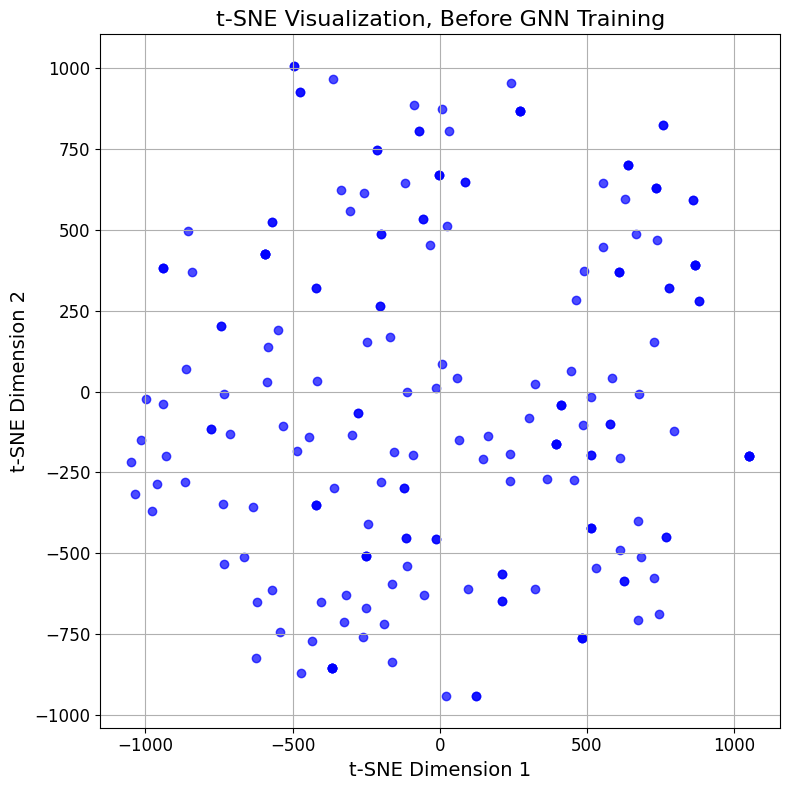

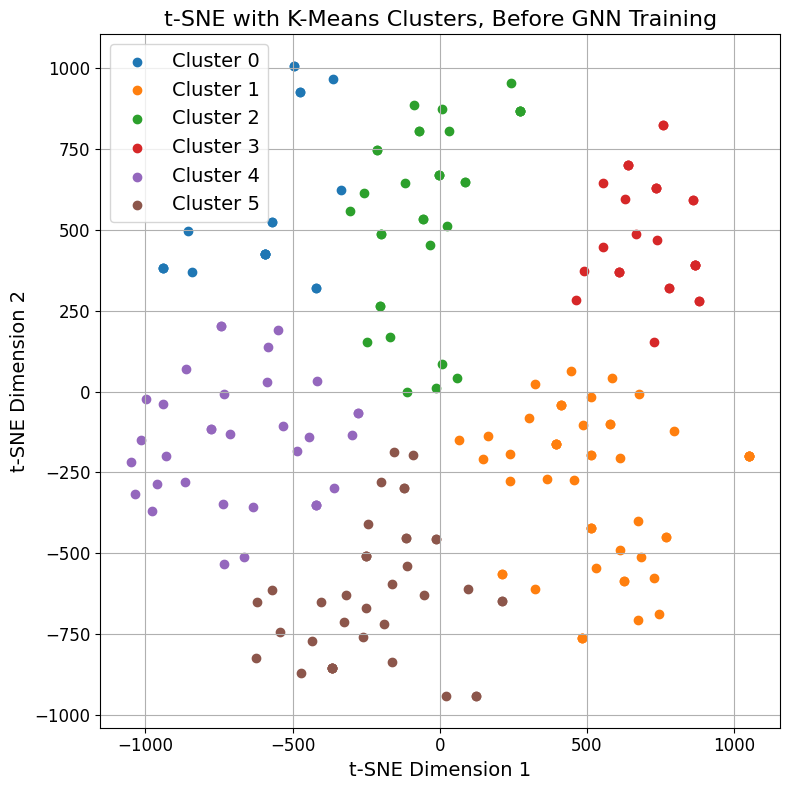

Cluster 5: (count: 40)
Ticks lasted: 811
Remaining time: 2736
Remaining rocks: 15
Victim harm: 247
Round num: 5

Cluster 3: (count: 29)
Ticks lasted: 1089
Remaining time: 2595
Remaining rocks: 11
Victim harm: 300
Round num: 5

Cluster 0: (count: 20)
Ticks lasted: 534
Remaining time: 2681
Remaining rocks: 16
Victim harm: 445
Round num: 4

Cluster 2: (count: 34)
Ticks lasted: 1119
Remaining time: 2429
Remaining rocks: 14
Victim harm: 208
Round num: 5

Cluster 4: (count: 34)
Ticks lasted: 1432
Remaining time: 2858
Remaining rocks: 20
Victim harm: 323
Round num: 4

Cluster 1: (count: 52)
Ticks lasted: 686
Remaining time: 2391
Remaining rocks: 13
Victim harm: 355
Round num: 5

Closest point to centroid of Cluster 0: situation
Closest point to centroid of Cluster 1: situation
Closest point to centroid of Cluster 2: situation
Closest point to centroid of Cluster 3: situation
Closest point to centroid of Cluster 4: situation
Closest point to centroid of Cluster 5: situation


In [190]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


node_features = []
for data_sample in tqdm(dataset):
    node_features_ = np.array(
        [
            node_features_
            for node_features_, is_small_dim_ in zip(
                data_sample.node_features, data_sample.is_small_dim
            )
            if is_small_dim_ == 0
        ]
    ).mean(axis=0)
    node_features.append(node_features_)
node_features = np.array(node_features)

# Apply t-SNE to reduce dimensions to 2D for visualization
tsne = TSNE(
    n_components=2,
    perplexity=30,  # Good balance for most datasets
    n_iter=2000,  # Enough for convergence
    learning_rate=200,  # Default, balanced value
    metric="euclidean",  # Use cosine for high-dimensional data
    init="pca",  # Stable initialization
    random_state=42,  # Reproducible results
)

vectors_2d = tsne.fit_transform(node_features)

# Plot the 2D visualization
plt.figure(figsize=(8, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c="blue", alpha=0.7)
plt.title("t-SNE Visualization, Before GNN Training", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)
plt.grid()

# Change the fontsize for the ticks
plt.tick_params(axis='both', which='major', labelsize=12)  # For major ticks
plt.tick_params(axis='both', which='minor', labelsize=10)  # For minor ticks (optional)

# Save and show the plot
plt.tight_layout()
plt.savefig("./figures/t-SNE Visualization, Before GNN Training.png")
plt.savefig("./figures/t-SNE Visualization, Before GNN Training.pdf")
plt.show()

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume `tsne_results` is the 2D output of t-SNE (shape: [num_points, 2])
# Number of clusters to form
num_clusters = 6

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_2d)

# Visualize the clusters
plt.figure(figsize=(8, 8))

for cluster in range(num_clusters):
    plt.scatter(
        vectors_2d[cluster_labels == cluster, 0],
        vectors_2d[cluster_labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.legend(fontsize=14, loc="best")
plt.grid()
plt.title("t-SNE with K-Means Clusters, Before GNN Training", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)

# Change the fontsize for the ticks
plt.tick_params(axis='both', which='major', labelsize=12)  # For major ticks
plt.tick_params(axis='both', which='minor', labelsize=10)  # For minor ticks (optional)

# Save and show the plot
plt.tight_layout()
plt.savefig("./figures/t-SNE with K-Means Clusters, Before GNN Training.png")
plt.savefig("./figures/t-SNE with K-Means Clusters, Before GNN Training.pdf")
plt.show()

from collections import Counter

cluster_dict = dict(Counter(cluster_labels))

ticks_lasted = []
remaining_time = []
remaining_rocks = []
victim_harm = []
round_num = []

for vertex in situation_vertices:
    cp_vertex = humemai.g.V(vertex).inE("has_situation").outV().next()
    properties = humemai.get_properties(cp_vertex)
    ticks_lasted.append(properties["ticks_lasted"])
    remaining_time.append(properties["remaining_time"])
    remaining_rocks.append(properties["remaining_rocks"])
    victim_harm.append(properties["victim_harm"])
    round_num.append(properties["round_num"])

ticks_lasted = np.array(ticks_lasted)
remaining_time = np.array(remaining_time)
remaining_rocks = np.array(remaining_rocks)
victim_harm = np.array(victim_harm)
round_num = np.array(round_num)

for label, val in cluster_dict.items():
    print(f"Cluster {label}: (count: {val})")
    print(f"Ticks lasted: {int(ticks_lasted[cluster_labels == label].mean())}")
    print(f"Remaining time: {int(remaining_time[cluster_labels == label].mean())}")
    print(f"Remaining rocks: {int(remaining_rocks[cluster_labels == label].mean())}")
    print(f"Victim harm: {int(victim_harm[cluster_labels == label].mean())}")
    print(f"Round num: {int(round_num[cluster_labels == label].mean())}")
    print()

import numpy as np

# Get the cluster centroids from K-Means
centroids = kmeans.cluster_centers_

# Find the closest data point to each centroid
closest_points = []

for cluster_id in range(num_clusters):
    # Get the indices of points in the current cluster
    cluster_points = vectors_2d[cluster_labels == cluster_id]
    original_indices = np.where(cluster_labels == cluster_id)[0]

    # Compute the distances to the centroid
    distances = np.linalg.norm(cluster_points - centroids[cluster_id], axis=1)

    # Find the index of the closest point
    closest_point_idx = original_indices[np.argmin(distances)]
    closest_points.append(closest_point_idx)

# Output the closest data points for each cluster
for cluster_id, point_idx in enumerate(closest_points):
    print(
        f"Closest point to centroid of Cluster {cluster_id}: {situation_vertices[point_idx].label}"
    )

## Define classes and functions for training RGCN

In [139]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import add_self_loops
import random


class RGCN(torch.nn.Module):
    """
    RGCN model for node classification.

    Attributes:
        small_dim (int): The dimension of small-dimensional node features.
        big_dim (int): The dimension of big-dimensional node features.
        num_hidden_channels (int): The number of hidden channels in the RGCN layers.
        num_edge_types (int): The number of edge types in the RGCN model.
        num_node_types (int): The number of node types in the RGCN model.

    Methods:
        forward(node_features, edge_index, edge_type, is_small_dim): Forward pass of the model.

    Example:
        model = RGCN(small_dim=5, big_dim=768, num_hidden_channels=64, num_edge_types=9, num_node_types=10)
        output = model(node_features, edge_index, edge_type, is_small_dim)

        # node_features is [num_nodes, small_dim or big_dim]
        # is_small_dim is a boolean mask: True where node features were originally M-dim

        # output is [num_nodes, num_node_types]

    """

    def __init__(
        self, small_dim, big_dim, num_hidden_channels, num_edge_types, num_node_types
    ):
        """
        Initialize the RGCN model.

        Args:
            small_dim (int): The dimension of small-dimensional node features.
            big_dim (int): The dimension of big-dimensional node features.
            num_hidden_channels (int): The number of hidden channels in the RGCN layers.
            num_edge_types (int): The number of edge types in the RGCN model.
            num_node_types (int): The number of node types in the RGCN model.

        """

        super().__init__()
        # This MLP will be used to upscale small_dim features to big_dim
        self.small_dim = small_dim
        self.big_dim = big_dim
        self.upscale = Linear(small_dim, big_dim)

        # After upscaling, all features are big_dim
        self.conv1 = RGCNConv(big_dim, num_hidden_channels, num_edge_types)
        self.conv2 = RGCNConv(num_hidden_channels, num_hidden_channels, num_edge_types)
        self.fc = Linear(num_hidden_channels, num_node_types)

    def forward(self, node_features, edge_index, edge_type, is_small_dim):
        """
        Forward pass of the RGCN model.

        Args:
            node_features (torch.Tensor): The node features tensor.
            edge_index (torch.Tensor): The edge index tensor.
            edge_type (torch.Tensor): The edge type tensor.
            is_small_dim (torch.Tensor): The boolean mask tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        # node_features is [num_nodes, small_dim or big_dim]
        # is_m_dim is a boolean mask: True where node features were originally M-dim

        # Upscale only those nodes that are small_dim
        # Extract small_dim node features (only first small_dim entries are relevant)

        # shape: [num_small_dim_nodes, small_dim]
        small_dim_nodes = node_features[is_small_dim, : self.small_dim]

        # shape: [num_small_dim_nodes, big_dim]
        small_dim_nodes_upscaled = self.upscale(small_dim_nodes)

        # Replace the small_dim node rows in node_features with the upscaled features
        node_features_new = node_features.clone()
        node_features_new[is_small_dim] = small_dim_nodes_upscaled
        node_features = node_features_new

        # Now all nodes are effectively big_dim
        self.node_features_1 = self.conv1(node_features, edge_index, edge_type)
        self.node_features_1_relu = F.relu(self.node_features_1)
        self.node_features_2 = self.conv2(
            self.node_features_1_relu, edge_index, edge_type
        )
        self.output = self.fc(self.node_features_2)

        return self.output


def count_parameters(model):
    """
    Count the number of trainable parameters in a model.

    Args:
        model (torch.nn.Module): The model to count parameters for.

    Returns:
        int: The number of trainable parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_rgcn(
    model,
    dataset,
    num_edge_types,
    num_hidden_channels,
    batch_size,
    num_epochs,
    small_dim,
    big_dim,
    device,
    num_node_types,
) -> dict:
    """
    Train an RGCN model on the given dataset.

    Args:
        model (torch.nn.Module): The RGCN model to train.
        dataset (torch_geometric.data.Data): The dataset to use for training.
        num_edge_types (int): The number of edge types in the dataset.
        num_hidden_channels (int): The number of hidden channels in the model.
        batch_size (int): The batch size to use for training.
        num_epochs (int): The number of epochs to train the model for.
        small_dim (int): The dimension of small-dimensional node features.
        big_dim (int): The dimension of big-dimensional node features.
        device (torch.device): The device to use for training the model.
        num_node_types (int): The number of node types in the dataset.

    Returns:
        dict: A dictionary containing the training loss and accuracy for each epoch.
    """
    stats = {"loss": [], "accuracy": []}
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(
                batch.node_features,
                batch.edge_index,
                batch.edge_type,
                batch.is_small_dim,
            )

            # Compute loss
            loss = loss_fn(out, batch.node_classes)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(out, dim=1)  # Get predicted class indices
            correct_predictions += (predicted == batch.node_classes).sum().item()
            total_samples += batch.node_classes.size(0)

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(loader)
        accuracy = correct_predictions / total_samples

        print(
            f"Mode {relation_mode}, Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}"
        )

        stats["loss"].append(avg_loss)
        stats["accuracy"].append(accuracy)

    return stats

## Train!

Training with include_self_loop_and_inv relations:
number of parameters: 128874
Mode include_self_loop_and_inv, Epoch 1, Loss: 2.2951, Accuracy: 0.1380
Mode include_self_loop_and_inv, Epoch 2, Loss: 2.2321, Accuracy: 0.2251
Mode include_self_loop_and_inv, Epoch 3, Loss: 2.1708, Accuracy: 0.2417
Mode include_self_loop_and_inv, Epoch 4, Loss: 2.1152, Accuracy: 0.2728
Mode include_self_loop_and_inv, Epoch 5, Loss: 2.0574, Accuracy: 0.3610
Mode include_self_loop_and_inv, Epoch 6, Loss: 1.9982, Accuracy: 0.4616
Mode include_self_loop_and_inv, Epoch 7, Loss: 1.9396, Accuracy: 0.4876
Mode include_self_loop_and_inv, Epoch 8, Loss: 1.8781, Accuracy: 0.5052
Mode include_self_loop_and_inv, Epoch 9, Loss: 1.8186, Accuracy: 0.5073
Mode include_self_loop_and_inv, Epoch 10, Loss: 1.7583, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 11, Loss: 1.6972, Accuracy: 0.5301
Mode include_self_loop_and_inv, Epoch 12, Loss: 1.6374, Accuracy: 0.5384
Mode include_self_loop_and_inv, Epoch 13, Loss: 1.577

/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Mode include_self_loop_and_inv, Epoch 15, Loss: 1.4594, Accuracy: 0.6079
Mode include_self_loop_and_inv, Epoch 16, Loss: 1.4037, Accuracy: 0.6390
Mode include_self_loop_and_inv, Epoch 17, Loss: 1.3492, Accuracy: 0.6504
Mode include_self_loop_and_inv, Epoch 18, Loss: 1.2948, Accuracy: 0.7344
Mode include_self_loop_and_inv, Epoch 19, Loss: 1.2406, Accuracy: 0.7469
Mode include_self_loop_and_inv, Epoch 20, Loss: 1.1931, Accuracy: 0.7573
Mode include_self_loop_and_inv, Epoch 21, Loss: 1.1460, Accuracy: 0.8050
Mode include_self_loop_and_inv, Epoch 22, Loss: 1.1007, Accuracy: 0.8122
Mode include_self_loop_and_inv, Epoch 23, Loss: 1.0575, Accuracy: 0.8278
Mode include_self_loop_and_inv, Epoch 24, Loss: 1.0172, Accuracy: 0.8309
Mode include_self_loop_and_inv, Epoch 25, Loss: 0.9797, Accuracy: 0.8413
Mode include_self_loop_and_inv, Epoch 26, Loss: 0.9458, Accuracy: 0.8600
Mode include_self_loop_and_inv, Epoch 27, Loss: 0.9092, Accuracy: 0.8454
Mode include_self_loop_and_inv, Epoch 28, Loss: 0.8

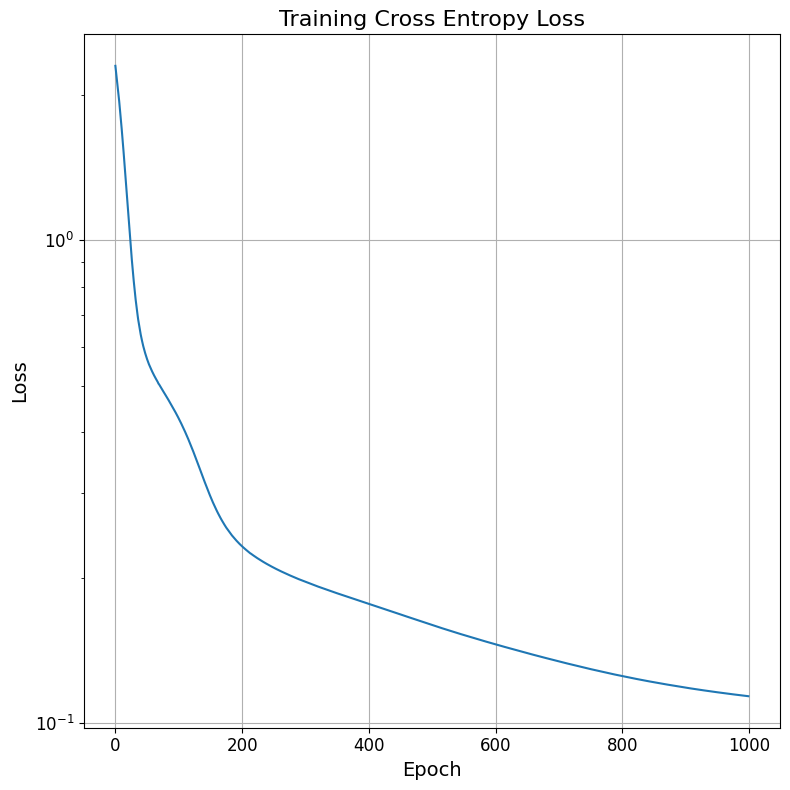

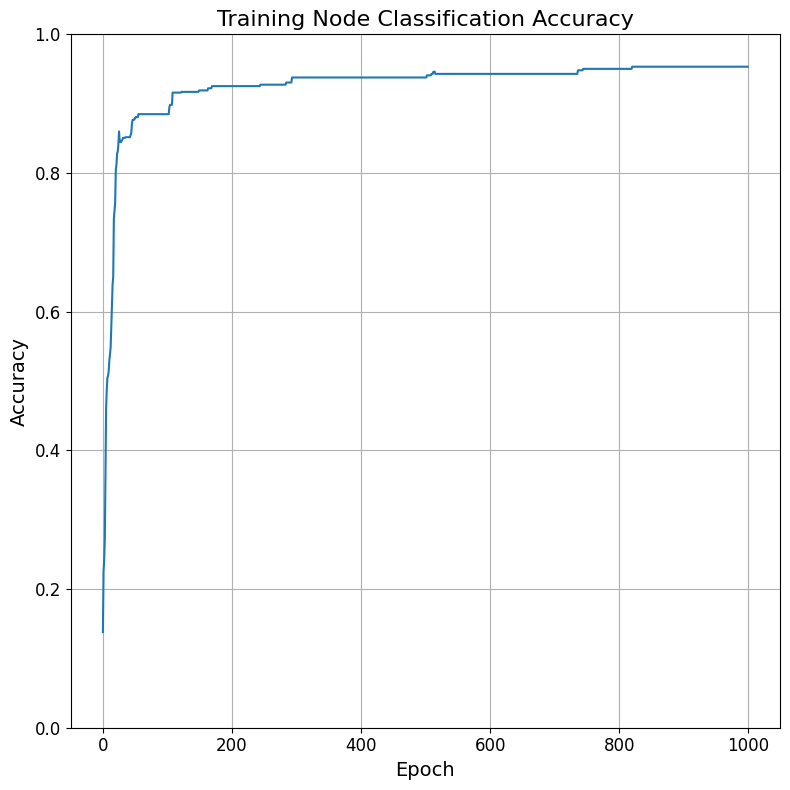

In [264]:
num_epochs = 1000
batch_size = len(dataset)
num_hidden_channels = 8
device = "cuda"
print(f"Training with {relation_mode} relations:")


model = RGCN(
    small_dim=small_dim,
    big_dim=big_dim,
    num_hidden_channels=num_hidden_channels,
    num_edge_types=num_edge_types,
    num_node_types=num_node_types,
).to(device)
print(f"number of parameters: {count_parameters(model)}")


stats = train_rgcn(
    model=model,
    dataset=dataset,
    num_edge_types=num_edge_types,
    num_hidden_channels=num_hidden_channels,
    batch_size=batch_size,
    num_epochs=num_epochs,
    small_dim=small_dim,
    big_dim=big_dim,
    device=device,
    num_node_types=num_node_types,
)

plt.figure(figsize=(8, 8))
plt.plot(stats["loss"], label="Loss")
plt.title("Training Cross Entropy Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale("log")

# Change the fontsize for the ticks
plt.tick_params(axis="both", which="major", labelsize=12)  # For major ticks
plt.tick_params(axis="both", which="minor", labelsize=10)  # For minor ticks (optional)

plt.grid()
plt.tight_layout()
plt.savefig("./figures/Training Cross Entropy Loss.png")
plt.savefig("./figures/Training Cross Entropy Loss.pdf")
plt.show()

plt.figure(figsize=(8, 8))
# make the plot tight
plt.plot(stats["accuracy"], label="Accuracy")
plt.title("Training Node Classification Accuracy", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)

# Change the fontsize for the ticks
plt.tick_params(axis="both", which="major", labelsize=12)  # For major ticks
plt.tick_params(axis="both", which="minor", labelsize=10)  # For minor ticks (optional)

plt.grid()
plt.tight_layout()
plt.savefig("./figures/Training Node Classification Accuracy.png")
plt.savefig("./figures/Training Node Classification Accuracy.pdf")
plt.show()

## Visualize again (after training)

### Represent every graph as one vector by the mean of the node_features

100%|██████████| 209/209 [00:01<00:00, 206.63it/s]
/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


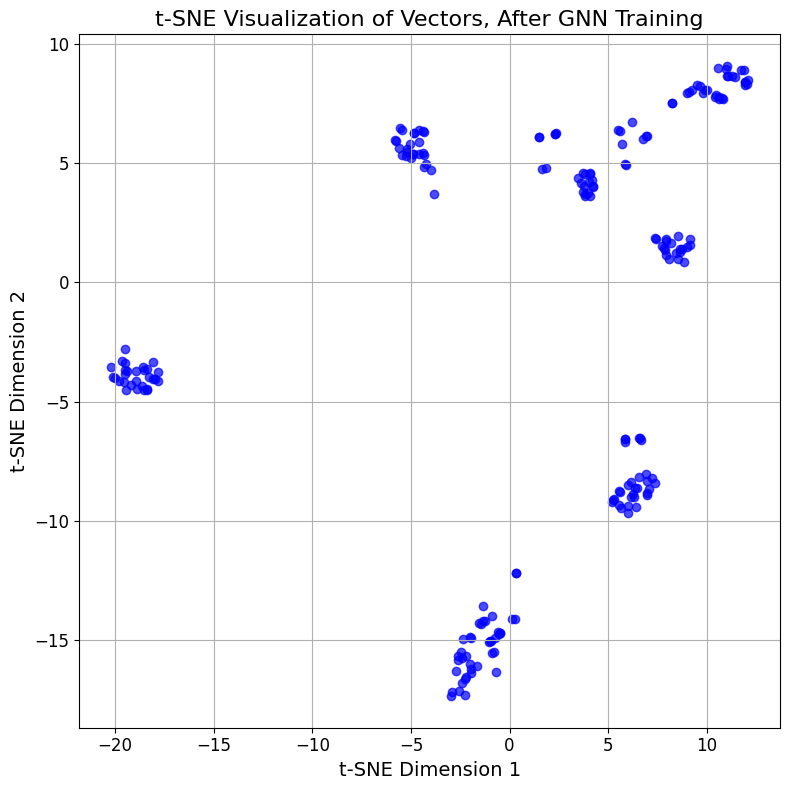

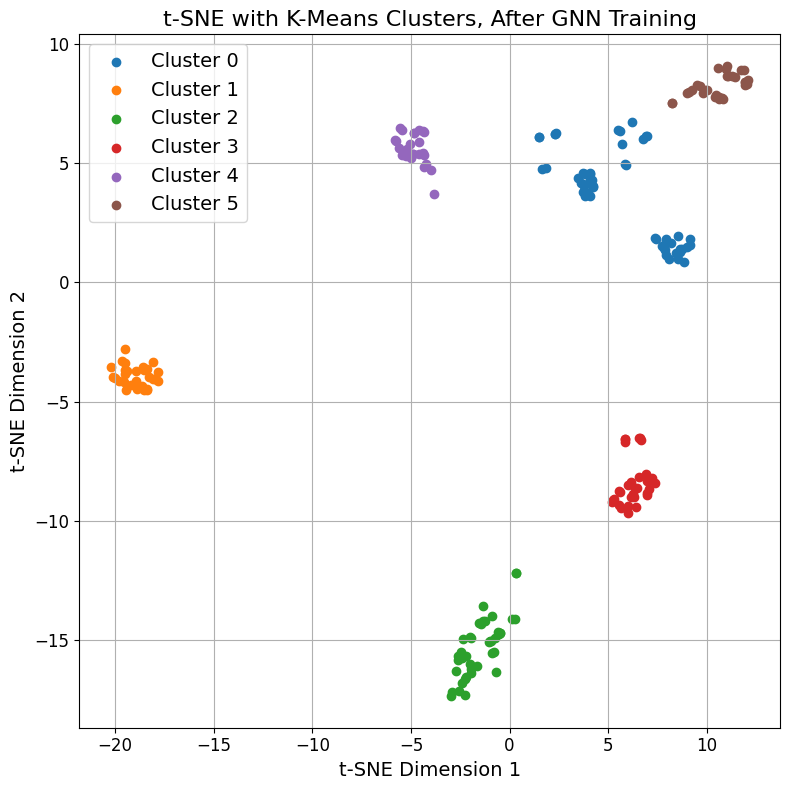

Cluster 5: (count: 30)
Ticks lasted: 608
Remaining time: 2869
Remaining rocks: 18
Victim harm: 246
Round num: 4

Cluster 4: (count: 26)
Ticks lasted: 1287
Remaining time: 2852
Remaining rocks: 14
Victim harm: 307
Round num: 5

Cluster 0: (count: 52)
Ticks lasted: 1049
Remaining time: 2693
Remaining rocks: 19
Victim harm: 313
Round num: 4

Cluster 3: (count: 31)
Ticks lasted: 893
Remaining time: 2420
Remaining rocks: 9
Victim harm: 341
Round num: 5

Cluster 2: (count: 41)
Ticks lasted: 650
Remaining time: 2290
Remaining rocks: 12
Victim harm: 300
Round num: 5

Cluster 1: (count: 29)
Ticks lasted: 1259
Remaining time: 2525
Remaining rocks: 13
Victim harm: 327
Round num: 5

Closest point to centroid of Cluster 0: CP 167
Closest point to centroid of Cluster 1: CP 203
Closest point to centroid of Cluster 2: CP 88
Closest point to centroid of Cluster 3: CP 181
Closest point to centroid of Cluster 4: CP 210
Closest point to centroid of Cluster 5: CP 28


In [265]:
node_features = []
for data_sample in tqdm(dataset):
    with torch.no_grad():
        prediction = model(
            data_sample.node_features.to(device),
            data_sample.edge_index.to(device),
            data_sample.edge_type.to(device),
            data_sample.is_small_dim.to(device),
        )
    node_features.append(model.node_features_2.mean(dim=0).clone())

node_features = torch.stack(node_features).detach().cpu().numpy()

# Apply t-SNE to reduce dimensions to 2D for visualization
tsne = TSNE(
    n_components=2,
    perplexity=30,  # Good balance for most datasets
    n_iter=2000,  # Enough for convergence
    learning_rate=200,  # Default, balanced value
    metric="euclidean",  # Use cosine for high-dimensional data
    init="pca",  # Stable initialization
    random_state=42,  # Reproducible results
)

vectors_2d = tsne.fit_transform(node_features)

# Plot the 2D visualization
plt.figure(figsize=(8, 8))

plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c="blue", alpha=0.7)
plt.title("t-SNE Visualization of Vectors, After GNN Training", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)
plt.grid()

# Change the fontsize for the ticks
plt.tick_params(axis='both', which='major', labelsize=12)  # For major ticks
plt.tick_params(axis='both', which='minor', labelsize=10)  # For minor ticks (optional)

plt.tight_layout()
plt.savefig("./figures/t-SNE Visualization of Vectors, After GNN Training.png")
plt.savefig("./figures/t-SNE Visualization of Vectors, After GNN Training.pdf")
plt.show()

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume `tsne_results` is the 2D output of t-SNE (shape: [num_points, 2])
# Number of clusters to form
num_clusters = 6

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_2d)

# Visualize the clusters
plt.figure(figsize=(8, 8))
for cluster in range(num_clusters):
    plt.scatter(
        vectors_2d[cluster_labels == cluster, 0],
        vectors_2d[cluster_labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.title("t-SNE with K-Means Clusters, After GNN Training", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)

# Change the fontsize for the ticks
plt.tick_params(axis='both', which='major', labelsize=12)  # For major ticks
plt.tick_params(axis='both', which='minor', labelsize=10)  # For minor ticks (optional)

# change the legend fontsize
plt.legend(fontsize=14, loc="best")
plt.grid()

plt.tight_layout()
plt.savefig("./figures/t-SNE with K-Means Clusters, After GNN Training.png")
plt.savefig("./figures/t-SNE with K-Means Clusters, After GNN Training.pdf")
plt.show()

from collections import Counter

cluster_dict = dict(Counter(cluster_labels))

ticks_lasted = []
remaining_time = []
remaining_rocks = []
victim_harm = []
round_num = []

for vertex in situation_vertices:
    cp_vertex = humemai.g.V(vertex).inE("has_situation").outV().next()
    properties = humemai.get_properties(cp_vertex)
    ticks_lasted.append(properties["ticks_lasted"])
    remaining_time.append(properties["remaining_time"])
    remaining_rocks.append(properties["remaining_rocks"])
    victim_harm.append(properties["victim_harm"])
    round_num.append(properties["round_num"])

ticks_lasted = np.array(ticks_lasted)
remaining_time = np.array(remaining_time)
remaining_rocks = np.array(remaining_rocks)
victim_harm = np.array(victim_harm)
round_num = np.array(round_num)

for label, val in cluster_dict.items():
    print(f"Cluster {label}: (count: {val})")
    print(f"Ticks lasted: {int(ticks_lasted[cluster_labels == label].mean())}")
    print(f"Remaining time: {int(remaining_time[cluster_labels == label].mean())}")
    print(f"Remaining rocks: {int(remaining_rocks[cluster_labels == label].mean())}")
    print(f"Victim harm: {int(victim_harm[cluster_labels == label].mean())}")
    print(f"Round num: {int(round_num[cluster_labels == label].mean())}")
    print()

import numpy as np

# Get the cluster centroids from K-Means
centroids = kmeans.cluster_centers_

# Find the closest data point to each centroid
closest_points = []

for cluster_id in range(num_clusters):
    # Get the indices of points in the current cluster
    cluster_points = vectors_2d[cluster_labels == cluster_id]
    original_indices = np.where(cluster_labels == cluster_id)[0]

    # Compute the distances to the centroid
    distances = np.linalg.norm(cluster_points - centroids[cluster_id], axis=1)

    # Find the index of the closest point
    closest_point_idx = original_indices[np.argmin(distances)]
    closest_points.append(closest_point_idx)


# Output the closest data points for each cluster
for cluster_id, point_idx in enumerate(closest_points):
    cp_vertex = humemai.g.V(situation_vertices[point_idx]).inE("has_situation").outV().next()
    cp_num = humemai.get_properties(cp_vertex)["cp_num"]
    print(
        f"Closest point to centroid of Cluster {cluster_id}: CP {cp_num}"
    )

In [266]:
import numpy as np

# Create a dictionary to hold all CP numbers for each cluster
cluster_cp_dict = {}

for cluster_id in range(num_clusters):
    # Get indices of points belonging to the current cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    
    # Collect CP numbers for all points in the cluster
    cp_nums = []
    for idx in cluster_indices:
        cp_vertex = humemai.g.V(situation_vertices[idx]).inE("has_situation").outV().next()
        cp_num = humemai.get_properties(cp_vertex)["cp_num"]
        cp_nums.append(cp_num)

    # Store them in the dictionary (optional)
    cluster_cp_dict[cluster_id] = cp_nums
    
    # Print them if desired
    print(f"All CP numbers in Cluster {cluster_id}: {cp_nums}")

# Now cluster_cp_dict contains all CP numbers keyed by cluster ID


All CP numbers in Cluster 0: [178, 30, 25, 119, 147, 76, 193, 59, 190, 27, 23, 22, 85, 146, 60, 20, 148, 75, 36, 153, 144, 70, 187, 167, 8, 57, 84, 169, 183, 83, 168, 10, 37, 175, 74, 81, 82, 73, 77, 64, 24, 12, 151, 15, 80, 26, 180, 121, 58, 6, 137, 19]
All CP numbers in Cluster 1: [61, 150, 208, 194, 179, 50, 205, 188, 113, 116, 117, 189, 91, 203, 182, 200, 185, 39, 152, 115, 209, 195, 207, 114, 191, 196, 160, 206, 199]
All CP numbers in Cluster 2: [72, 101, 94, 67, 105, 62, 164, 120, 33, 111, 112, 103, 108, 95, 89, 102, 69, 90, 34, 104, 68, 92, 65, 110, 66, 163, 31, 106, 63, 109, 135, 40, 107, 35, 88, 71, 93, 100, 32, 86, 87]
All CP numbers in Cluster 3: [197, 172, 181, 171, 126, 134, 123, 131, 192, 177, 184, 176, 174, 128, 97, 132, 201, 139, 127, 198, 204, 136, 138, 130, 125, 96, 129, 202, 186, 122, 124]
All CP numbers in Cluster 4: [143, 157, 56, 159, 44, 51, 29, 155, 145, 118, 210, 149, 53, 52, 133, 161, 42, 38, 54, 162, 173, 47, 158, 165, 154, 156]
All CP numbers in Cluster 5: [

In [267]:
vertices, edges = humemai.get_within_hops([humemai.g.V().has("cp_num", 88).outE().inV().next()], 1)
for vertex in vertices:
    try:
        print(vertex.label, humemai.get_properties(vertex)["sentence_representation"])
    except:
        print(vertex.label, humemai.get_properties(vertex))

situation Location: Top of rock pile. Object: Large rock. 
CP {'num_recalled': 0, 'cp_num': 88, 'ticks_lasted': 183, 'remaining_time': 1313, 'participant_num': 4087, 'remaining_rocks': 0, 'cp_name': 'Move', 'victim_harm': 0, 'vector_representation': '[0.06063618290258449, 0.43766666666666665, 0.0, 0.0, 0.5]', 'round_num': 4, 'event_time': '2024-07-03T10:34:18'}
robot_action Action: Drop <object> in <location>. Location: <Right> side of field. Object: Large rock. 
robot_action Action: Pick up <object> in <location>. Location: Top of rock pile. Object: Large rock. 


### `g.V().has("cp_num", 88)`
![cp_88.png](./figures/cp_88.png)

In [268]:
from collections import Counter

for key, val in cluster_cp_dict.items():
    print(f"Cluster {key}:")
    vertex_labels = []
    edge_labels = []

    # Collect labels
    for cp_num in val:
        vertices, edges = humemai.get_within_hops(
            [humemai.g.V().has("cp_num", cp_num).outE().inV().next()],
            1
        )
        for vertex in vertices:
            vertex_labels.append(vertex.label)
        for edge in edges:
            edge_labels.append(edge.label)

    # Filter out labels you do NOT want to see
    vertex_labels = [v for v in vertex_labels if v not in ("situation", "CP")]
    edge_labels   = [e for e in edge_labels if e != "has_situation"]

    # Count and sort in descending order
    vertex_labels_counter = Counter(vertex_labels)
    edge_labels_counter   = Counter(edge_labels)
    vertex_labels_sorted  = vertex_labels_counter.most_common()  # returns list sorted by count desc
    edge_labels_sorted    = edge_labels_counter.most_common()

    # Totals for percentage calculation
    total_vertex_labels = sum(vertex_labels_counter.values())
    total_edge_labels   = sum(edge_labels_counter.values())

    print("Vertex labels (descending order with percentages):")
    for label, count in vertex_labels_sorted:
        percentage = (count / total_vertex_labels) * 100
        print(f"  {label}: {count} ({percentage:.2f}%)")

    print("\nEdge labels (descending order with percentages):")
    for label, count in edge_labels_sorted:
        percentage = (count / total_edge_labels) * 100
        print(f"  {label}: {count} ({percentage:.2f}%)")

    print("-" * 50, "\n")


Cluster 0:
Vertex labels (descending order with percentages):
  robot_action: 122 (59.80%)
  human_action: 82 (40.20%)

Edge labels (descending order with percentages):
  has_robot_action_0: 51 (25.00%)
  has_human_action_0: 48 (23.53%)
  has_robot_action_1: 45 (22.06%)
  has_human_action_1: 29 (14.22%)
  has_robot_action_2: 12 (5.88%)
  has_robot_action_3: 11 (5.39%)
  has_human_action_2: 5 (2.45%)
  has_robot_action_4: 3 (1.47%)
-------------------------------------------------- 

Cluster 1:
Vertex labels (descending order with percentages):
  robot_action: 29 (100.00%)

Edge labels (descending order with percentages):
  has_robot_action_0: 29 (100.00%)
-------------------------------------------------- 

Cluster 2:
Vertex labels (descending order with percentages):
  robot_action: 82 (97.62%)
  human_action: 2 (2.38%)

Edge labels (descending order with percentages):
  has_robot_action_1: 41 (48.81%)
  has_robot_action_0: 41 (48.81%)
  has_human_action_1: 2 (2.38%)
-----------------